In [1]:
import librosa
import os
import librosa.display
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import time
import pandas as pd
import keras

Using TensorFlow backend.


ImportError: Traceback (most recent call last):
  File "/home/matheus/.local/share/virtualenvs/audios-bdt1HvIq/lib/python3.7/site-packages/tensorflow/python/pywrap_tensorflow.py", line 58, in <module>
    from tensorflow.python.pywrap_tensorflow_internal import *
  File "/home/matheus/.local/share/virtualenvs/audios-bdt1HvIq/lib/python3.7/site-packages/tensorflow/python/pywrap_tensorflow_internal.py", line 28, in <module>
    _pywrap_tensorflow_internal = swig_import_helper()
  File "/home/matheus/.local/share/virtualenvs/audios-bdt1HvIq/lib/python3.7/site-packages/tensorflow/python/pywrap_tensorflow_internal.py", line 24, in swig_import_helper
    _mod = imp.load_module('_pywrap_tensorflow_internal', fp, pathname, description)
  File "/home/matheus/.local/share/virtualenvs/audios-bdt1HvIq/lib/python3.7/imp.py", line 242, in load_module
    return load_dynamic(name, filename, file)
  File "/home/matheus/.local/share/virtualenvs/audios-bdt1HvIq/lib/python3.7/imp.py", line 342, in load_dynamic
    return _load(spec)
ImportError: /home/matheus/.local/share/virtualenvs/audios-bdt1HvIq/lib/python3.7/site-packages/tensorflow/python/_pywrap_tensorflow_internal.so: invalid ELF header


Failed to load the native TensorFlow runtime.

See https://www.tensorflow.org/install/errors

for some common reasons and solutions.  Include the entire stack trace
above this error message when asking for help.

In [19]:
librosa.get_duration(filename='./fma_small/006/006329.mp3')

29.9

In [28]:
def audio_to_image(filepath, savepath='./images/'):
    
    filepath = os.path.abspath(filepath)
    savepath = os.path.abspath(savepath)
    mpl.rcParams['savefig.pad_inches'] = 0
    # Reads every audio file from filepath, returns amplitude in time(y) and sample rate(sr)
    for folder in os.listdir(filepath):
        folderpath = '{}/{}'.format(filepath, folder)
        
        for filename in os.listdir(folderpath):
            fullpath = '{}/{}'.format(folderpath, filename)
            print(fullpath)
            audio_wave, sample_rate = librosa.load(fullpath)

            # Applies Fourier transform in audio's amplitude
            fourier = librosa.stft(audio_wave)

            # Converts amplitude to DBs
            """
            ref:scalar or callable
                If scalar, the amplitude abs(S) is scaled relative to ref: 20 * log10(S / ref). 
                Zeros in the output correspond to positions where S == ref.

                If callable, the reference value is computed as ref(S).
            """
            D = librosa.amplitude_to_db(np.abs(fourier), ref=np.max)
            
           
            librosa.display.specshow(D, x_axis='time', y_axis='log')
            plt.axis('off')
            #plt.axis('off')
            
            savefolder = '{}/{}'.format(savepath, folder)
            
            if not os.path.exists(savefolder):
                os.makedirs(savefolder)
            
            plt.savefig(savefolder + '/' + filename.split('.')[0] + '-spectogram.png', bbox_inches='tight',  pad_inches=0)

/home/matheus/Documentos/visao-computacional/audios/teste/038/038353.mp3
/home/matheus/Documentos/visao-computacional/audios/teste/038/038312.mp3
/home/matheus/Documentos/visao-computacional/audios/teste/038/038352.mp3
/home/matheus/Documentos/visao-computacional/audios/teste/038/038351.mp3
/home/matheus/Documentos/visao-computacional/audios/teste/038/038323.mp3
/home/matheus/Documentos/visao-computacional/audios/teste/038/038326.mp3
/home/matheus/Documentos/visao-computacional/audios/teste/038/038354.mp3
/home/matheus/Documentos/visao-computacional/audios/teste/038/038321.mp3
/home/matheus/Documentos/visao-computacional/audios/teste/005/005159.mp3
/home/matheus/Documentos/visao-computacional/audios/teste/005/005156.mp3
/home/matheus/Documentos/visao-computacional/audios/teste/005/005169.mp3
/home/matheus/Documentos/visao-computacional/audios/teste/005/005158.mp3
/home/matheus/Documentos/visao-computacional/audios/teste/005/005006.mp3
/home/matheus/Documentos/visao-computacional/audios

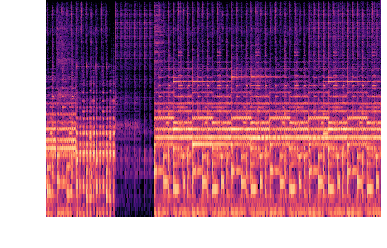

In [30]:
audio_to_image('./teste/')

In [1]:
df_tracks = pd.read_csv('fma_metadata/tracks.csv')

NameError: name 'pd' is not defined

In [1]:
df_genres = pd.read_csv('fma_metadata/genres.csv')

NameError: name 'pd' is not defined

In [9]:
df_tracks.head()

,track_id,bit_rate,comments,composer,date_created,date_recorded,duration,favorites,genre_top,genres,...,publisher,tags,title,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27
0,2,256000,0,NaN,2008-11-26 01:48:12,2008-11-26 00:00:00,168,2,Hip-Hop,[21],...,NaN,[],Food,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3,256000,0,NaN,2008-11-26 01:48:14,2008-11-26 00:00:00,237,1,Hip-Hop,[21],...,NaN,[],Electric Ave,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5,256000,0,NaN,2008-11-26 01:48:20,2008-11-26 00:00:00,206,6,Hip-Hop,[21],...,NaN,[],This World,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10,192000,0,Kurt Vile,2008-11-25 17:49:06,2008-11-26 00:00:00,161,178,Pop,[10],...,NaN,[],Freeway,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,20,256000,0,NaN,2008-11-26 01:48:56,2008-01-01 00:00:00,311,0,NaN,"[76, 103]",...,NaN,[],Spiritual Level,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
df_tracks

,track_id,bit_rate,comments,composer,date_created,date_recorded,duration,favorites,genre_top,genres,...,publisher,tags,title,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27
0,2,256000,0,NaN,2008-11-26 01:48:12,2008-11-26 00:00:00,168,2,Hip-Hop,[21],...,NaN,[],Food,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3,256000,0,NaN,2008-11-26 01:48:14,2008-11-26 00:00:00,237,1,Hip-Hop,[21],...,NaN,[],Electric Ave,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5,256000,0,NaN,2008-11-26 01:48:20,2008-11-26 00:00:00,206,6,Hip-Hop,[21],...,NaN,[],This World,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10,192000,0,Kurt Vile,2008-11-25 17:49:06,2008-11-26 00:00:00,161,178,Pop,[10],...,NaN,[],Freeway,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,20,256000,0,NaN,2008-11-26 01:48:56,2008-01-01 00:00:00,311,0,NaN,"[76, 103]",...,NaN,[],Spiritual Level,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,26,256000,0,NaN,2008-11-26 01:49:05,2008-01-01 00:00:00,181,0,NaN,"[76, 103]",...,NaN,[],Where is your Love?,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,30,256000,0,NaN,2008-11-26 01:49:11,2008-01-01 00:00:00,174,0,NaN,"[76, 103]",...,NaN,[],Too Happy,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,46,256000,0,NaN,2008-11-26 01:49:53,2008-01-01 00:00:00,104,0,NaN,"[76, 103]",...,NaN,[],Yosemite,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,48,256000,0,NaN,2008-11-26 01:49:56,2008-01-01 00:00:00,205,0,NaN,"[76, 103]",...,NaN,[],Light of Light,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,134,256000,0,NaN,2008-11-26 01:43:19,2008-11-26 00:00:00,207,3,Hip-Hop,[21],...,NaN,[],Street Music,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
df_genres.shape

(163, 5)

In [ ]:
for 